## Data Preprocessing Stage 2

In [1]:
# Importing all the libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import csv

# Machine Learning models
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation file
import evaluation

In [2]:
# Loading the saved datasets from data preprocessing stage 1 notebook
train_data = pd.read_csv("proData/train_data.csv")
train_labels = pd.read_csv("proData/train_labels.csv")
test_data = pd.read_csv("proData/test_data.csv")
test_labels = pd.read_csv("proData/test_labels.csv")

In [3]:
numerical_vars = ['age', 'bp', 'sg', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv']
categorical_vars = ['pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [4]:
# Creating numerical and categorical datasets again
numerical_df_train = train_data[numerical_vars]
categorical_df_train = train_data[categorical_vars]

numerical_df_test = test_data[numerical_vars]
categorical_df_test = test_data[categorical_vars]

In [5]:
# Finding the correlation between numerical data and dependent feature
numeric_dict = {}
for feature in numerical_vars:
    cor, _ = pointbiserialr(train_labels['class'], numerical_df_train[feature])
    
    # Determining the direction of the association
    if cor > 0:
        direction = "Positive association"
    elif cor < 0:
        direction = "Negative association"
    else:
        direction = "No association"
    
    # Determining the strength of the association
    abs_corr = abs(cor)
    if abs_corr < 0.1:
        strength = "Weak"
    elif abs_corr < 0.3:
        strength = "Moderate"
    else:
        strength = "Strong"
    
    # saving the values in a dictionary
    numeric_dict[feature] = {
        'Correlation': cor,
        'Direction': direction,
        'Strength': strength
    }

In [6]:
# Checking the results
print(numeric_dict)

{'age': {'Correlation': 0.23380939629710418, 'Direction': 'Positive association', 'Strength': 'Moderate'}, 'bp': {'Correlation': 0.3269059895997275, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'sg': {'Correlation': -0.7234330584746711, 'Direction': 'Negative association', 'Strength': 'Strong'}, 'bgr': {'Correlation': 0.41630431885904984, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'bu': {'Correlation': 0.41229507244120334, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'sc': {'Correlation': 0.3258583058835229, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'sod': {'Correlation': -0.3612520779504548, 'Direction': 'Negative association', 'Strength': 'Strong'}, 'pot': {'Correlation': 0.08810339076786518, 'Direction': 'Positive association', 'Strength': 'Weak'}, 'hemo': {'Correlation': -0.762379232748079, 'Direction': 'Negative association', 'Strength': 'Strong'}, 'pcv': {'Correlation': -0.7149594783201385, 'Direction': 'Negative as

In [7]:
# Finding the correlation between categorical data and dependent feature
categorical_dict = {}
for _, feature in enumerate(categorical_df_train):
    cont_table = np.array(pd.crosstab(train_labels['class'], categorical_df_train[feature], rownames=None,colnames=None))
    chi2, pval, dof, expected = chi2_contingency(cont_table)

    # Checking the conditions for positive, negative or no association
    observed_proportions = cont_table / np.sum(cont_table)
    expected_proportions = expected / np.sum(expected)
    
    if observed_proportions[0, 0] > expected_proportions[0, 0] and observed_proportions[1, 1] > expected_proportions[1, 1]:
        direction = "Positive association"
    elif observed_proportions[0, 1] > expected_proportions[0, 1] and observed_proportions[1, 0] > expected_proportions[1, 0]:
        direction = "Negative association"
    else:
        direction = "No association"
    
    # Calculate Cramer's V
    obs = np.sum(cont_table)
    minDim = min(cont_table.shape) - 1
    V = np.sqrt(chi2 / (obs * minDim))
    
    # Determine the strength of the association
    if V < 0.1:
        strength = "Weak"
    elif V < 0.3:
        strength = "Moderate"
    else:
        strength = "Strong"

    # saving the values in a dictionary
    categorical_dict[feature] = {
        'chi2': chi2,
        'pval': pval,
        'dof': dof,
        'Expected': expected,
        'Cramers_v': V,
        'Direction': direction,
        'Strength': strength
    }

In [8]:
# Checking the results
print(categorical_dict)

{'pc': {'chi2': 64.16040100250626, 'pval': 1.146909199064601e-15, 'dof': 1, 'Expected': array([[171.5,  28.5],
       [171.5,  28.5]]), 'Cramers_v': 0.4005009394574071, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'pcc': {'chi2': 32.64266304347826, 'pval': 1.1075671643025504e-08, 'dof': 1, 'Expected': array([[184.,  16.],
       [184.,  16.]]), 'Cramers_v': 0.2856687900501132, 'Direction': 'Positive association', 'Strength': 'Moderate'}, 'ba': {'chi2': 13.575757575757576, 'pval': 0.00022912549645436189, 'dof': 1, 'Expected': array([[192.5,   7.5],
       [192.5,   7.5]]), 'Cramers_v': 0.18422647458873534, 'Direction': 'Positive association', 'Strength': 'Moderate'}, 'htn': {'chi2': 166.56000478483207, 'pval': 4.17387843759379e-38, 'dof': 1, 'Expected': array([[140.5,  59.5],
       [140.5,  59.5]]), 'Cramers_v': 0.6452906414648211, 'Direction': 'Positive association', 'Strength': 'Strong'}, 'dm': {'chi2': 147.09164853873074, 'pval': 7.493702355041378e-34, 'dof': 1, 'Expe

In [9]:
# Creating a dataframe to save all the values calculated till now
results = []

In [10]:
# Iterate over numerical features
for feature, corr_data in numeric_dict.items():
    results.append([feature, 'Numeric', 'pointbiserialr', corr_data['Correlation'], corr_data['Direction'], corr_data['Strength']])

# Iterate over categorical features
for feature, corr_data in categorical_dict.items():
    results.append([feature, 'Categorical', 'Chi Square test with Cramers V', corr_data['Cramers_v'], corr_data['Direction'], corr_data['Strength']])

In [11]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Feature', 'Type', 'Correlation Type', 'Value', 'Direction', 'Strength'])

In [12]:
output_dir = 'Selected Features'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [13]:
# Save results to CSV
results_df.to_csv('Selected Features/correlation_results.csv', index=False)

In [14]:
# Initializing lists to store selected features based on direction
selected_features = {
    'Positive': [],
    'Negative': []
}

In [15]:
# Iterate over categorical features for Categorical associations
for feature, corr_data in categorical_dict.items():
    if corr_data['Strength'] in ['Moderate', 'Strong']:
        if corr_data['Direction'] == 'Positive association':
            selected_features['Positive'].append((feature, corr_data['Cramers_v']))
        elif corr_data['Direction'] == 'Negative association':
            selected_features['Negative'].append((feature, corr_data['Cramers_v']))

# Iterate over numerical features for Numeric associations
for feature, corr_data in numeric_dict.items():
    if corr_data['Strength'] in ['Moderate', 'Strong']:
        if corr_data['Direction'] == 'Positive association':
            selected_features['Positive'].append((feature, corr_data['Correlation']))
        elif corr_data['Direction'] == 'Negative association':
            selected_features['Negative'].append((feature, corr_data['Correlation']))

# Sort selected features by association strength
selected_features['Positive'].sort(key=lambda x: x[1], reverse=True)
selected_features['Negative'].sort(key=lambda x: x[1], reverse=True)

In [16]:
# Initialize final lists for top 10 features
top_features = []
used_features = set()  # To track used features

# Choose top 10 features each for positive and negative associations
count_positive = min(5, len(selected_features['Positive']))
count_negative = min(5, len(selected_features['Negative']))

# Add top positive features
for feature, value in selected_features['Positive'][:count_positive]:
    if feature not in used_features:
        top_features.append((feature, 'Positive', value))
        used_features.add(feature)

# Add top negative features
for feature, value in selected_features['Negative'][:count_negative]:
    if feature not in used_features:
        top_features.append((feature, 'Negative', value))
        used_features.add(feature)

In [17]:
# If one side has fewer than 5 features, add more from the opposite side to make it 6
if len(top_features) < 10:
    remaining_needed = 10 - len(top_features)

    # Add additional positive features
    additional_positive = [(feature, 'Positive', value) for feature, value in selected_features['Positive'] if feature not in used_features][:remaining_needed]
    top_features.extend(additional_positive)
    used_features.update([feature for feature, _, _ in additional_positive])

    # Add additional negative features if still needed
    if len(top_features) < 10:
        additional_negative = [(feature, 'Negative', value) for feature, value in selected_features['Negative'] if feature not in used_features][:remaining_needed]
        top_features.extend(additional_negative)

In [18]:
# Converting to DataFrame
df = pd.DataFrame(top_features, columns=['Feature', 'Association', 'Strength'])

In [19]:
# checking the selected features
print(df)

  Feature Association  Strength
0     htn    Positive  0.645291
1      dm    Positive  0.606407
2     bgr    Positive  0.416304
3      pe    Positive  0.413083
4      bu    Positive  0.412295
5   appet    Negative  0.429616
6     sod    Negative -0.361252
7     pcv    Negative -0.714959
8      sg    Negative -0.723433
9    hemo    Negative -0.762379


In [20]:
# Saving the selected features with results
df.to_csv('Selected Features/selected_features.csv', index=False)

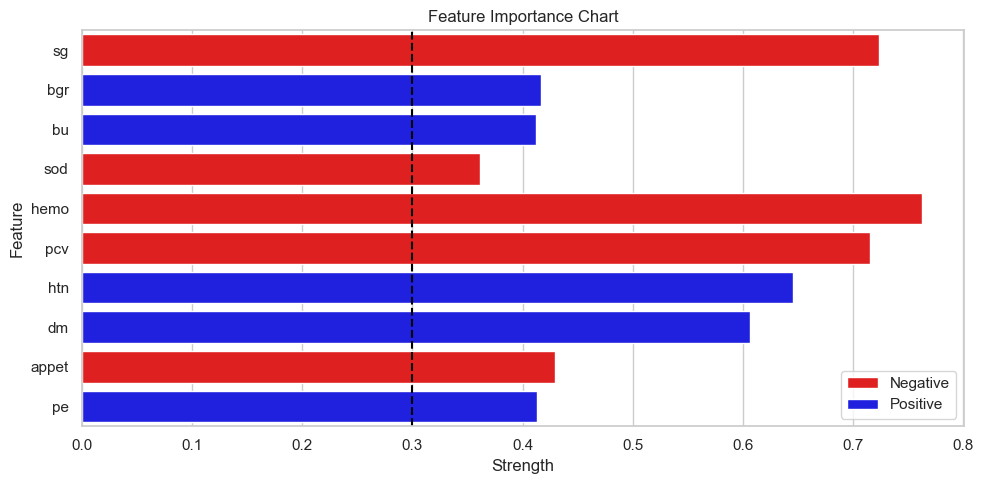

In [21]:
# Extract column names from the first dataset
column_names = train_data.columns

# Ensure the first column of df2 contains the row names that correspond to df1's columns
df_first_column = df.iloc[:, 0]

# Filter df2 to only include rows where the first column matches column names of df1
df_filtered = df[df_first_column.isin(column_names)]

# Reorder the rows in df2_filtered based on the order of df1's columns
df = df_filtered.set_index(df_first_column).reindex(column_names).dropna().reset_index()

# Creating a bar plot to visualization the results
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

df['Strength'] = df['Strength'].abs()

# Define barplot with hue for different colors for positive and negative associations
barplot = sns.barplot(x='Strength', y='Feature', hue='Association', data=df, palette={'Positive': 'blue', 'Negative': 'red'})

# Add vertical lines at -0.3 and 0.3
plt.axvline(x=0.3, color='black', linestyle='--')

# Add title and labels
plt.title('Feature Importance Chart')
plt.xlabel('Strength')
plt.ylabel('Feature')

# Adjust the legend
plt.legend(loc='lower right')

# Show plot
plt.tight_layout()
plt.show()

In [22]:
# Normalizing the numerical data
scaler = StandardScaler()
normalized_df_train = pd.DataFrame(scaler.fit_transform(numerical_df_train), columns=numerical_df_train.columns)
normalized_df_test = pd.DataFrame(scaler.transform(numerical_df_test), columns=numerical_df_test.columns)

In [23]:
print(normalized_df_train.head())
print(normalized_df_test.head())

        age        bp        sg       bgr        bu        sc       sod  \
0 -0.283727  2.946453 -0.689994 -0.106972 -0.790123 -0.321446 -0.038627   
1  0.986300 -0.477791 -0.689994  1.012797  0.374991 -0.104881 -0.038627   
2  0.409015 -0.477791  1.220812 -0.709925 -0.790123 -0.285352  0.954915   
3 -1.842396  0.378270  0.265409 -0.437161 -0.644484 -0.357540  0.292554   
4  0.235830 -0.477791 -1.645397 -0.394093  1.269631  0.598956 -0.480201   

        pot      hemo       pcv  
0 -0.048561 -0.140877 -0.048056  
1  0.448400 -1.254579 -1.543915  
2 -0.368036  1.274846  1.572458  
3 -0.119556  0.519794  0.450564  
4 -0.652014 -1.481095 -1.793225  
        age        bp        sg       bgr        bu        sc       sod  \
0  0.697658 -0.477791  1.220812 -0.106972 -0.353205 -0.321446  1.286096   
1 -0.341455 -0.477791  1.220812 -0.293600 -0.041121 -0.086834 -0.259414   
2  0.870843 -0.477791  0.265409  1.587037 -0.498845 -0.177069 -0.038627   
3  1.390400 -0.477791  1.220812  0.294996 -0.

In [24]:
# Concatenating the numeric and categorical datasets into train and test datasets
train_data = pd.concat([normalized_df_train, categorical_df_train], axis=1)
test_data = pd.concat([normalized_df_test, categorical_df_test], axis=1)

In [25]:
print(train_data.head())
print(test_data.head())

        age        bp        sg       bgr        bu        sc       sod  \
0 -0.283727  2.946453 -0.689994 -0.106972 -0.790123 -0.321446 -0.038627   
1  0.986300 -0.477791 -0.689994  1.012797  0.374991 -0.104881 -0.038627   
2  0.409015 -0.477791  1.220812 -0.709925 -0.790123 -0.285352  0.954915   
3 -1.842396  0.378270  0.265409 -0.437161 -0.644484 -0.357540  0.292554   
4  0.235830 -0.477791 -1.645397 -0.394093  1.269631  0.598956 -0.480201   

        pot      hemo       pcv   pc  pcc   ba  htn   dm  cad  appet   pe  ane  
0 -0.048561 -0.140877 -0.048056  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
1  0.448400 -1.254579 -1.543915  0.0  1.0  0.0  1.0  1.0  1.0    0.0  1.0  0.0  
2 -0.368036  1.274846  1.572458  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
3 -0.119556  0.519794  0.450564  0.0  0.0  0.0  0.0  0.0  0.0    1.0  0.0  0.0  
4 -0.652014 -1.481095 -1.793225  0.0  0.0  0.0  1.0  1.0  0.0    0.0  0.0  0.0  
        age        bp        sg       bgr        bu        sc  

In [26]:
# Saving the train and test datasets
train_data.to_csv('proData/train_data.csv', index=False)
test_data.to_csv('proData/test_data.csv', index=False)

### Training Machine learning Models

In [27]:
ml_names = ['lr', 'nb', 'dt', 'svm', 'knn']
lml_names = ['LR', 'NB', 'DT', 'SVM', 'KNN']

cml_names = ['blue', 'deeppink', 'crimson', 'aqua', 'gold']

In [28]:
# Fit logistic regression model
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
model_lr.fit(train_data, train_labels)

C:\Users\chand\Py_Env\ckd\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [29]:
# Fit Gaussian Naive Bayes model
model_nb = GaussianNB()
model_nb.fit(train_data, train_labels)

C:\Users\chand\Py_Env\ckd\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [30]:
# Fit Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(train_data, train_labels)

DecisionTreeClassifier(random_state=42)

In [31]:
# Fit Support Vector Machine Classifier (SVM) model
model_svm = SVC(kernel='linear', C=1, random_state=42, probability=True)
model_svm.fit(train_data, train_labels)

C:\Users\chand\Py_Env\ckd\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear', probability=True, random_state=42)

In [32]:
# Fit K-Nearest Neighbors model
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(train_data, train_labels)

C:\Users\chand\Py_Env\ckd\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10)

### Machine Learning models Evalutions

In [33]:
output_dir = 'models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [34]:
# Creating a dictionary for the trained models
ml_models = {
    'lr': model_lr,
    'nb': model_nb,
    'dt': model_dt,
    'svm': model_svm,
    'knn': model_knn
}

Confusion matrix of the model LR:
[[30  0]
 [ 1 49]]
True Negative of the model LR -> 30
False Positive of the model LR -> 0
False Negative of the model LR -> 1
True Positive of the model LR -> 49
Accuracy of the model LR -> 0.9875
Misclassification rate of the model LR -> 0.012499999999999956
Precision of the model LR -> 1.0
Recall of the model LR -> 0.98
F1 Measure of the model LR -> 0.98989898989899
Specificity of the model LR -> 1.0
MCC of the model LR -> 0.9738516810963534
AUC of the model LR -> 0.9993333333333333
Precision-Recall AUC of the model LR -> 0.9996078431372549




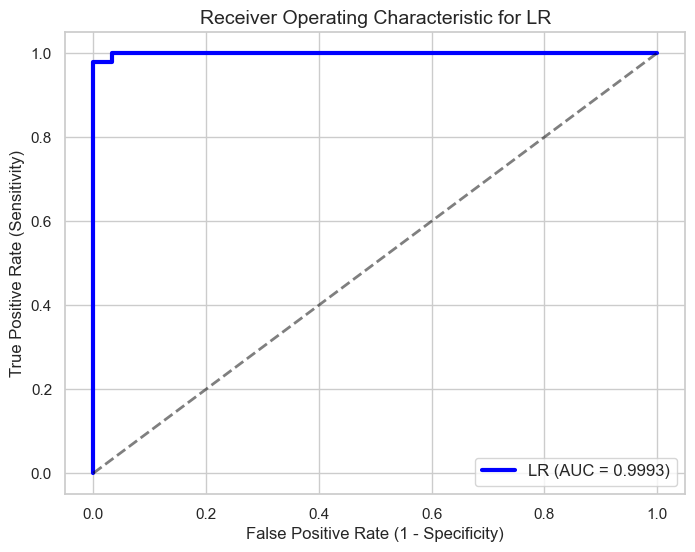

Confusion matrix of the model NB:
[[30  0]
 [ 4 46]]
True Negative of the model NB -> 30
False Positive of the model NB -> 0
False Negative of the model NB -> 4
True Positive of the model NB -> 46
Accuracy of the model NB -> 0.95
Misclassification rate of the model NB -> 0.050000000000000044
Precision of the model NB -> 1.0
Recall of the model NB -> 0.92
F1 Measure of the model NB -> 0.9583333333333334
Specificity of the model NB -> 1.0
MCC of the model NB -> 0.9009798587550961
AUC of the model NB -> 1.0
Precision-Recall AUC of the model NB -> 1.0




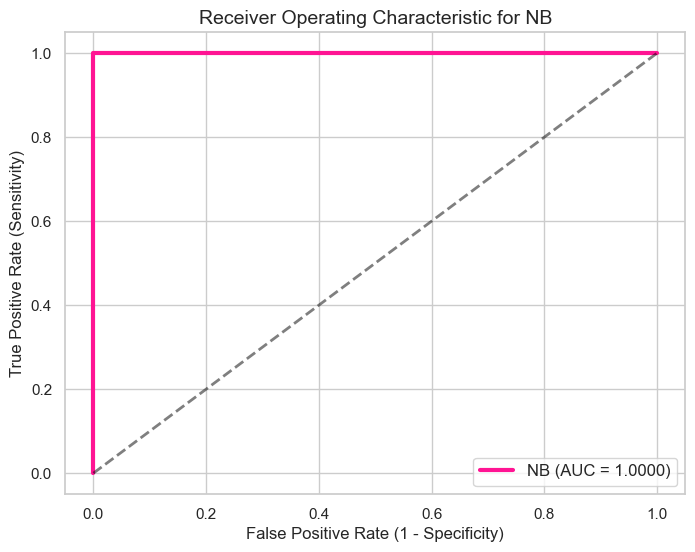

Confusion matrix of the model DT:
[[29  1]
 [ 0 50]]
True Negative of the model DT -> 29
False Positive of the model DT -> 1
False Negative of the model DT -> 0
True Positive of the model DT -> 50
Accuracy of the model DT -> 0.9875
Misclassification rate of the model DT -> 0.012499999999999956
Precision of the model DT -> 0.9803921568627451
Recall of the model DT -> 1.0
F1 Measure of the model DT -> 0.9900990099009901
Specificity of the model DT -> 0.9666666666666667
MCC of the model DT -> 0.973505222533836
AUC of the model DT -> 0.9833333333333334
Precision-Recall AUC of the model DT -> 0.9803921568627451




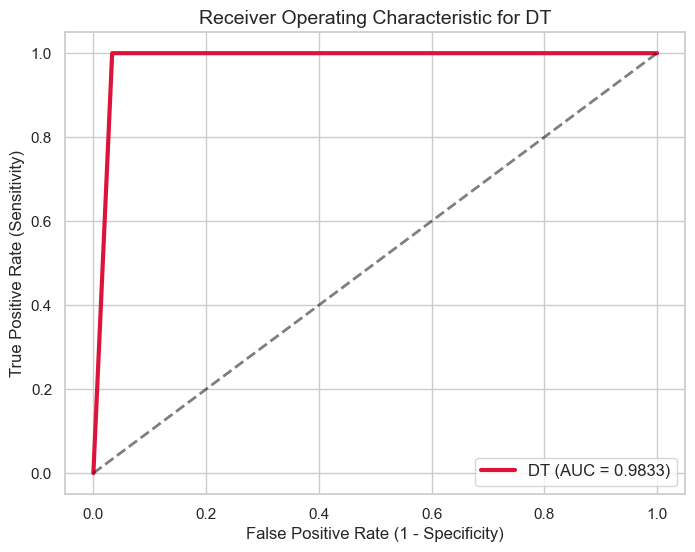

Confusion matrix of the model SVM:
[[29  1]
 [ 1 49]]
True Negative of the model SVM -> 29
False Positive of the model SVM -> 1
False Negative of the model SVM -> 1
True Positive of the model SVM -> 49
Accuracy of the model SVM -> 0.975
Misclassification rate of the model SVM -> 0.025000000000000022
Precision of the model SVM -> 0.98
Recall of the model SVM -> 0.98
F1 Measure of the model SVM -> 0.98
Specificity of the model SVM -> 0.9666666666666667
MCC of the model SVM -> 0.9466666666666667
AUC of the model SVM -> 0.9993333333333333
Precision-Recall AUC of the model SVM -> 0.9996078431372549




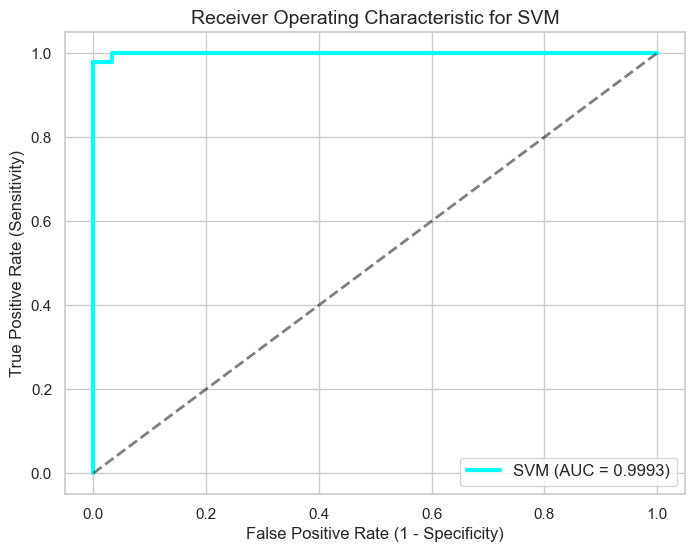

Confusion matrix of the model KNN:
[[30  0]
 [ 8 42]]
True Negative of the model KNN -> 30
False Positive of the model KNN -> 0
False Negative of the model KNN -> 8
True Positive of the model KNN -> 42
Accuracy of the model KNN -> 0.9
Misclassification rate of the model KNN -> 0.09999999999999998
Precision of the model KNN -> 1.0
Recall of the model KNN -> 0.84
F1 Measure of the model KNN -> 0.9130434782608695
Specificity of the model KNN -> 1.0
MCC of the model KNN -> 0.8143450710459553
AUC of the model KNN -> 1.0
Precision-Recall AUC of the model KNN -> 1.0




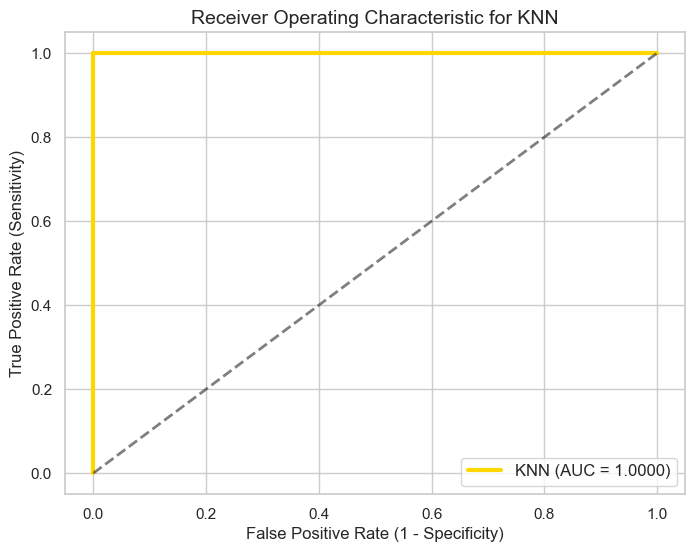

In [35]:
# Calculating the evaluation metrics on the trained models [Code in evaluation.py file]
roc_curves_data = evaluation.eval_function_with_roc_plot(ml_models, ml_names, lml_names, cml_names, test_data, test_labels)

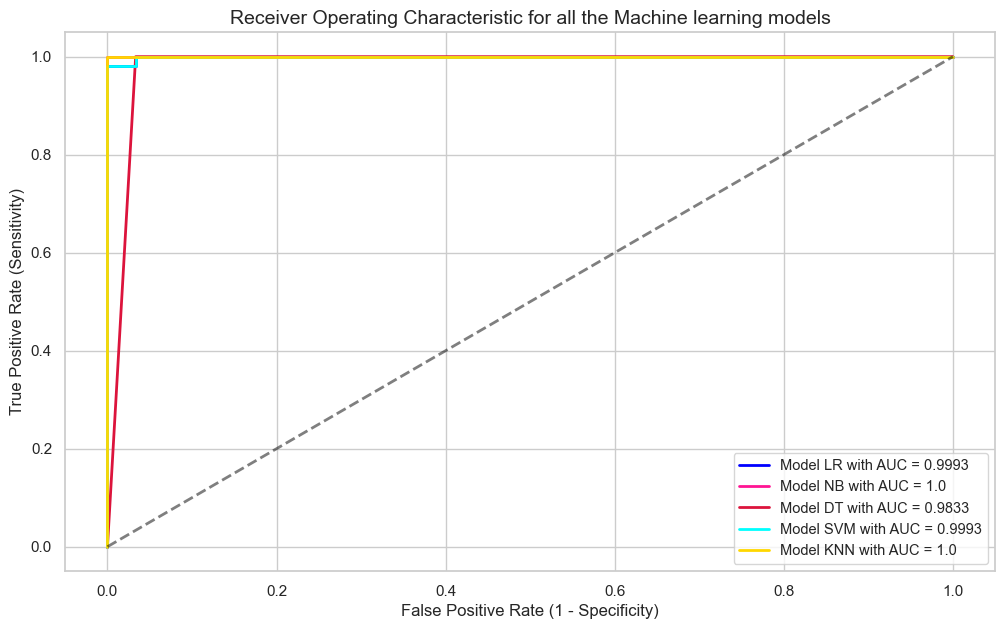

In [36]:
# Combined roc plot for the machine learning trained models
evaluation.plot_roc_curves([roc_curves_data], ['Machine'])

### Feature Importance using shap

In [37]:
# Calculating the best features using shap library
shap_values_dict = {}
for name, model in ml_models.items():
    if name in ['nb', 'knn']:
        explainer = shap.KernelExplainer(model.predict, train_data)
        shap_values = explainer.shap_values(test_data)
    elif name == "dt":
        explainer = shap.TreeExplainer(model, train_data)
        shap_values = explainer.shap_values(test_data)
    else:
        explainer = shap.Explainer(model, train_data)
        shap_values = explainer(test_data)
    shap_values_dict[name] = shap_values

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/80 [00:00<?, ?it/s]

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/80 [00:00<?, ?it/s]

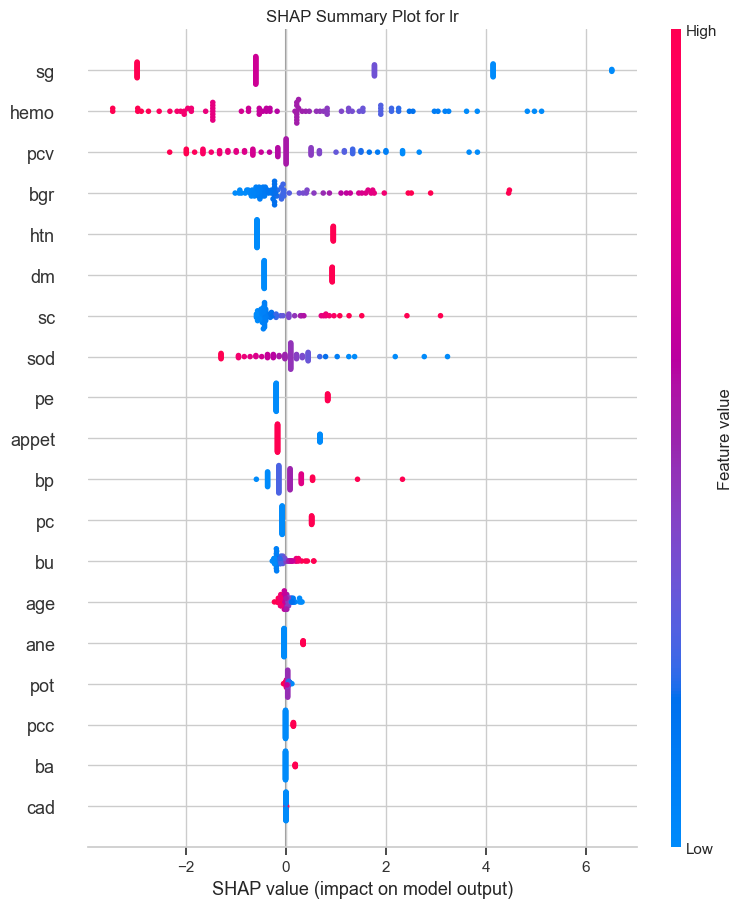

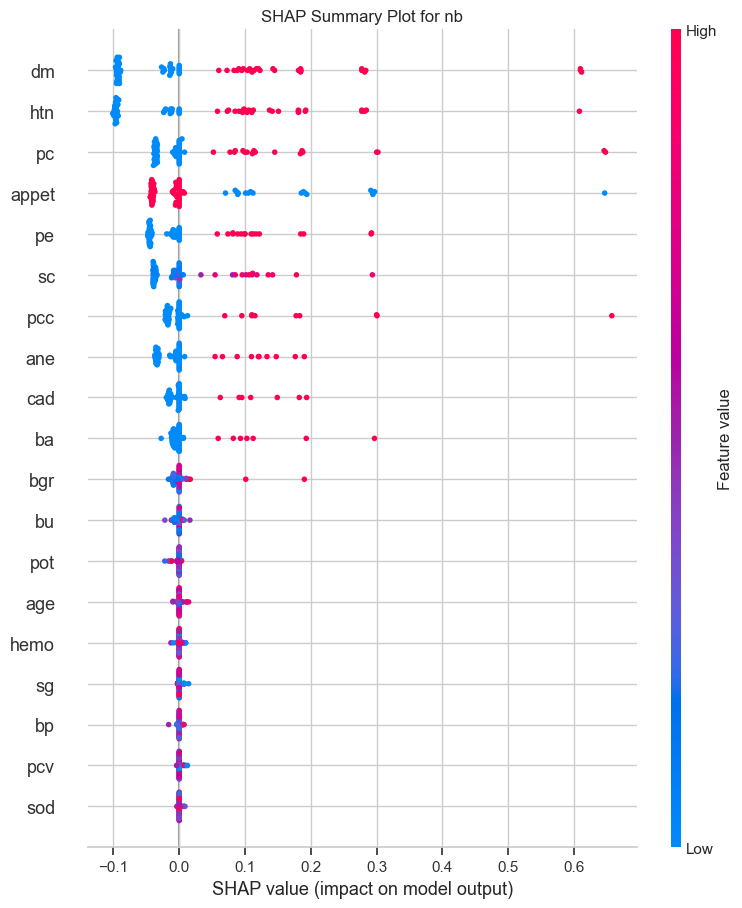

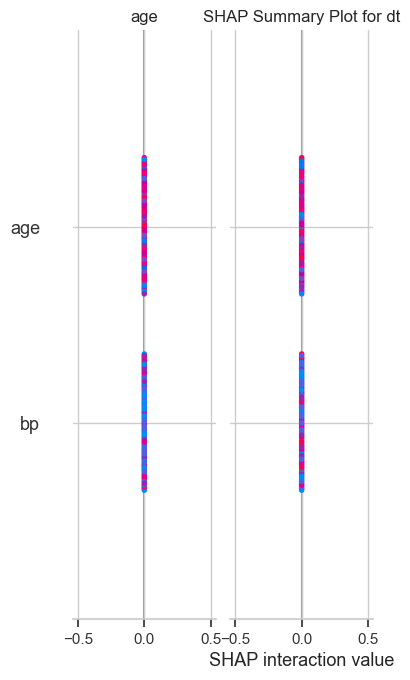

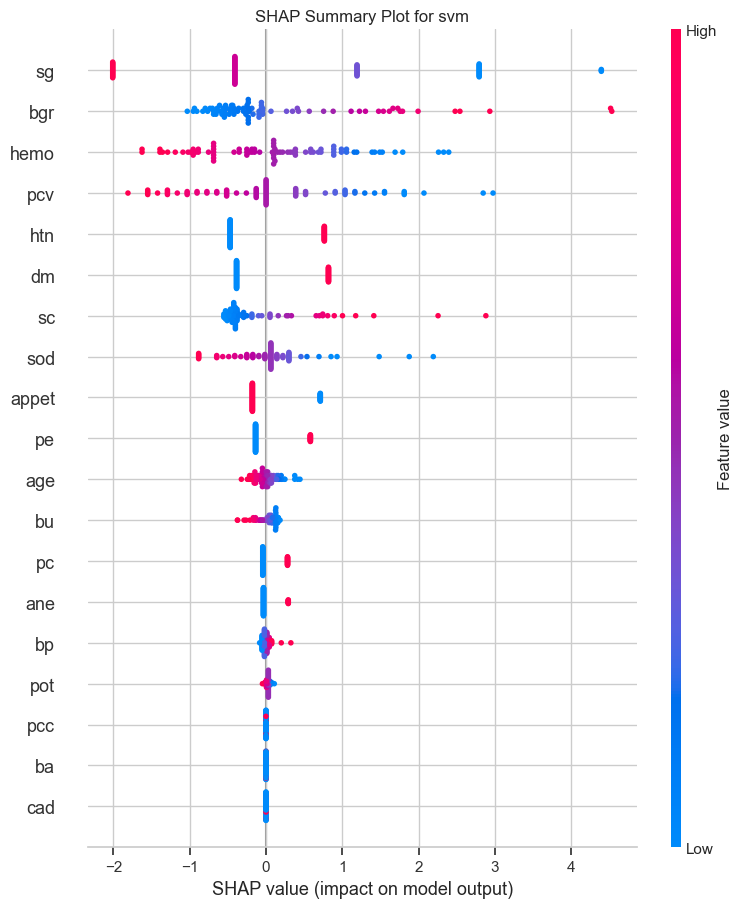

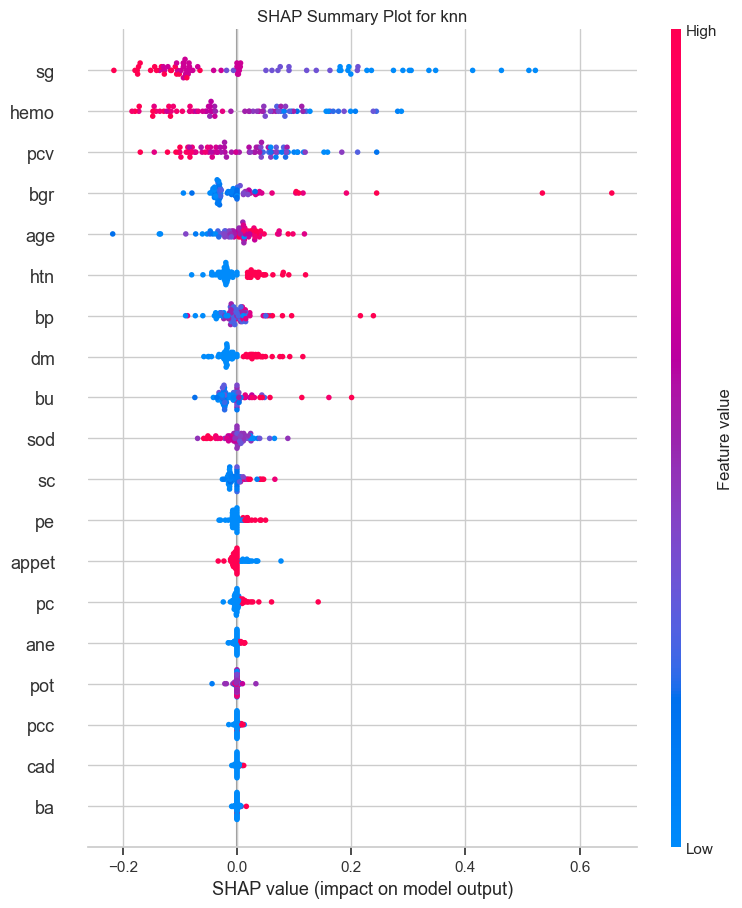

In [38]:
# Creating summary plots for all the machine learning models
for name, shap_values in shap_values_dict.items():
    shap.summary_plot(shap_values, test_data, show=False)
    plt.title(f'SHAP Summary Plot for {name}')
    plt.show()

In [39]:
# Applying mathematical operations on the calculated shap values to get the best features in order
feature_importance_df = pd.DataFrame(index=train_data.columns)

for name, shap_values in shap_values_dict.items():
    if hasattr(shap_values, 'values'):
        feature_importance = np.abs(shap_values.values).mean(axis=0)
    else:
        feature_importance = np.abs(shap_values).mean(axis=0)
    if name in ["dt", "knn"]:
        break
    else:
        feature_importance_df[name] = feature_importance

feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(by='mean_importance', ascending=False)

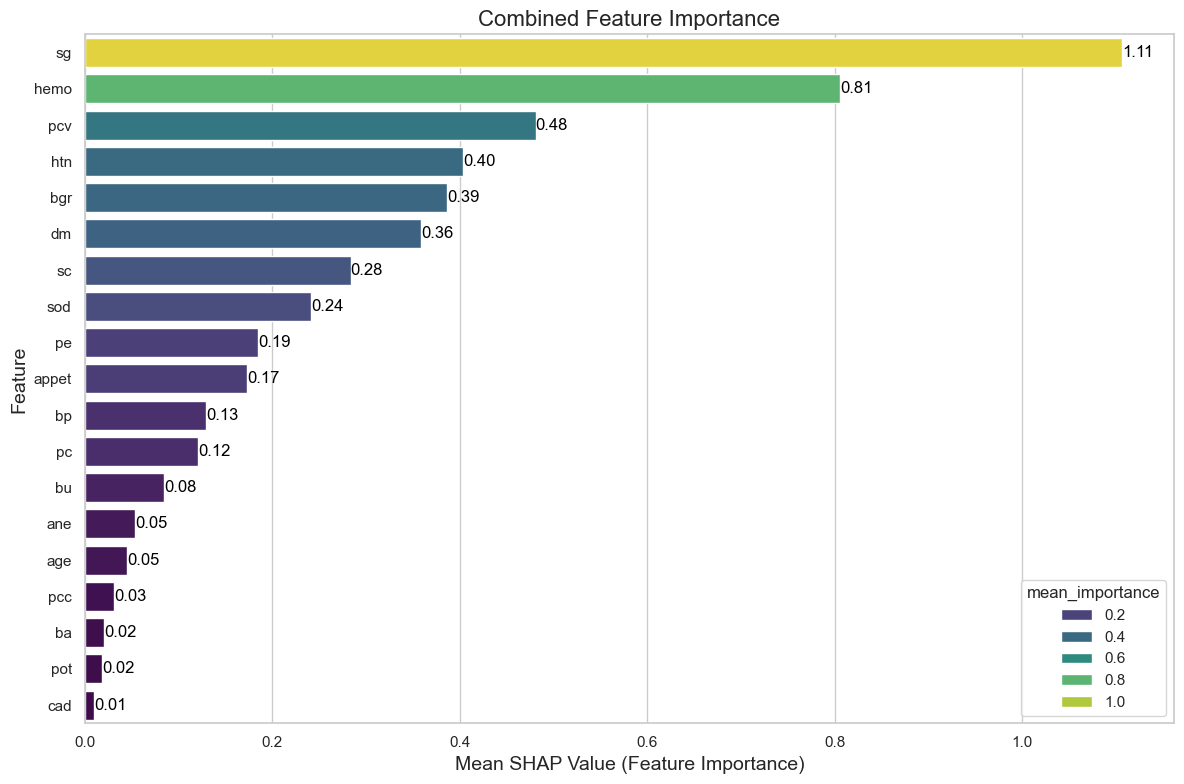

In [40]:
# Creating a best feature plot from shap values
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_df['mean_importance'], y=feature_importance_df.index, hue=feature_importance_df['mean_importance'], palette='viridis')
plt.title('Combined Feature Importance', fontsize=16)
plt.xlabel('Mean SHAP Value (Feature Importance)', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Annotate the bar plot with the importance values
for index, value in enumerate(feature_importance_df['mean_importance']):
    plt.text(value, index, f'{value:.2f}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()

In [41]:
# Saving the best features from shap to a CSV file
best_features = feature_importance_df.index.tolist()
best_features_df = pd.DataFrame(best_features, columns=['feature_name'])
best_features_df.to_csv('Selected Features/shap_features.csv', index=False)

In [42]:
# Checking the dataframe
print(best_features_df)

   feature_name
0            sg
1          hemo
2           pcv
3           htn
4           bgr
5            dm
6            sc
7           sod
8            pe
9         appet
10           bp
11           pc
12           bu
13          ane
14          age
15          pcc
16           ba
17          pot
18          cad
